In [35]:
#scientific libraries and plotting
import numpy as np
import scipy as scipy
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import math
import os
import random

#torch specific
import torch

#other libraries
import sys
from pathlib import Path
import atlas_mpl_style as ampl

In [19]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

In [20]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution
#LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
#PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
PLOT_LABELS = ["SPH_9", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
PLOT_ORDER = [0, 2, 1, 3, 5, 4]

CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000
CUT = True
LOAD = False
N_max = 45 #Maximum number of events measured
M = 100 #Number of experiments to average
STATISTIC = "binomial" # available statistics: ["poisson", "chi2"]

#Set data paths
if CUT:
    N_EVENTS = 15000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_15000_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 3000
    TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

#LOAD_FOLDER = "../results/models/experiment_resnet18_1703074946_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
MODEL_NAME = "resnet18_1703078471_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"


DEVICE = torch.device("cpu")
print("Running on the CPU")

ampl.use_atlas_style()   
#paper_colors = ['#4c72b0','#55a868', '#dd8452', '#c44e52',  '#937860', '#8172b3']
paper_colors = ['#4c72b0','#dd8452', '#55a868',  '#c44e52',  '#8172b3', '#937860']
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

Running on the CPU


In [21]:
#import model
model = ResNet18(img_channels=3, num_classes=CLASSES)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [22]:
#Load data
sph_testpath = [Path(TEST_DATAPATHS[0])]
sph_test_data = Hdf5Dataset(sph_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_1_testpath = [Path(TEST_DATAPATHS[1])]
bh_1_test_data = Hdf5Dataset(bh_1_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_2_testpath = [Path(TEST_DATAPATHS[2])]
bh_2_test_data = Hdf5Dataset(bh_2_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_3_testpath = [Path(TEST_DATAPATHS[3])]
bh_3_test_data = Hdf5Dataset(bh_3_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_4_testpath = [Path(TEST_DATAPATHS[4])]
bh_4_test_data = Hdf5Dataset(bh_4_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_5_testpath = [Path(TEST_DATAPATHS[5])]
bh_5_test_data = Hdf5Dataset(bh_5_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.


In [23]:
sph_truth, sph_preds, sph_values = shuffle_predict(model, sph_test_data, CLASSES, 100, RES, DEVICE, return_conf=True)
bh_1_truth, bh_1_preds, bh_1_values = shuffle_predict(model, bh_1_test_data, CLASSES, 100, RES, DEVICE, return_conf=True)
bh_2_truth, bh_2_preds, bh_2_values = shuffle_predict(model, bh_2_test_data, CLASSES, 100, RES, DEVICE, return_conf=True)
bh_3_truth, bh_3_preds, bh_3_values = shuffle_predict(model, bh_3_test_data, CLASSES, 100, RES, DEVICE, return_conf=True)
bh_4_truth, bh_4_preds, bh_4_values = shuffle_predict(model, bh_4_test_data, CLASSES, 100, RES, DEVICE, return_conf=True)
bh_5_truth, bh_5_preds, bh_5_values = shuffle_predict(model, bh_5_test_data, CLASSES, 100, RES, DEVICE, return_conf=True)


100%|██████████| 150/150 [00:18<00:00,  8.26it/s]


In [24]:
#Add data to dataframes
sph_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [sph_truth, sph_preds])))
bh_1_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_1_truth, bh_1_preds])))
bh_2_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_2_truth, bh_2_preds])))
bh_3_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_3_truth, bh_3_preds])))
bh_4_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_4_truth, bh_4_preds])))
bh_5_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_5_truth, bh_5_preds])))

datasets = [sph_df, bh_1_df, bh_2_df, bh_3_df, bh_4_df, bh_5_df]
output_values = [sph_values, bh_1_values, bh_2_values, bh_3_values, bh_4_values, bh_5_values]

keys = [f"class_{i}" for i in range(CLASSES)]
for i in range(CLASSES):
    for j in range(len(datasets)):
        datasets[i][keys[j]] = output_values[j][:, i]
    
print(bh_1_df.head())

   Truth  Predictions   class_0   class_1   class_2   class_3   class_4   class_5
0    1.0          1.0  0.092439  0.343805  0.320088  0.545852  0.440417  0.444256
1    1.0          1.0  0.038926  0.334152  0.220696  0.443307  0.278418  0.698481
2    1.0          5.0  0.003100  0.222816  0.349274  0.372519  0.024378  0.251869
3    1.0          3.0  0.013888  0.323438  0.056598  0.018217  0.000054  0.163580
4    1.0          5.0  0.039824  0.259858  0.234542  0.237658  0.000081  0.459735


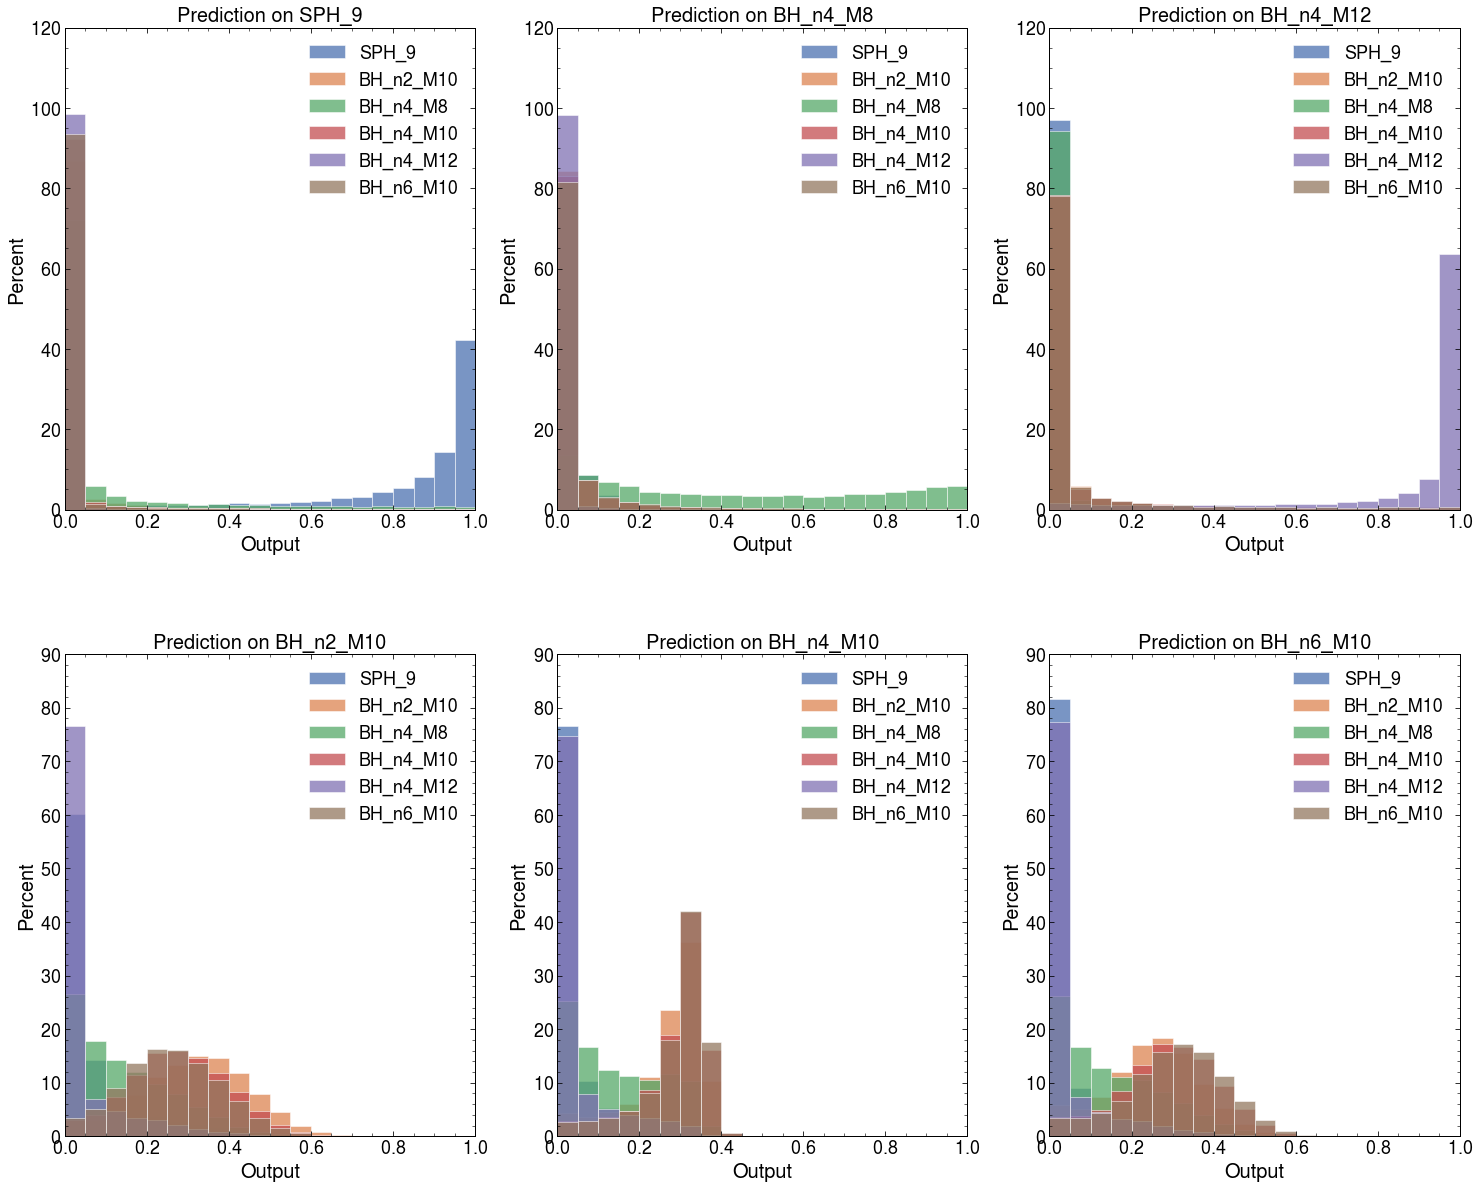

In [25]:
#Print the raw ML outputs before argmax
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
plt.subplots_adjust(hspace=0.3)
for i in range(CLASSES):
    for j in range(CLASSES):
        sn.histplot(datasets[i][f"class_{j}"], ax = ax[i%2][i//2], label=f"{PLOT_LABELS[j]}", color=paper_colors[j], binrange=[0, 1], bins=20, 
                    common_norm=False, multiple="layer", fill="False", stat="percent")
    ax[i%2][i//2].set_title(f"Prediction on {PLOT_LABELS[i]}")
    ax[i%2][i//2].legend()
    ax[i%2][i//2].set_xlim(0, 1)
    ax[i%2][i//2].set_xlabel("Output")


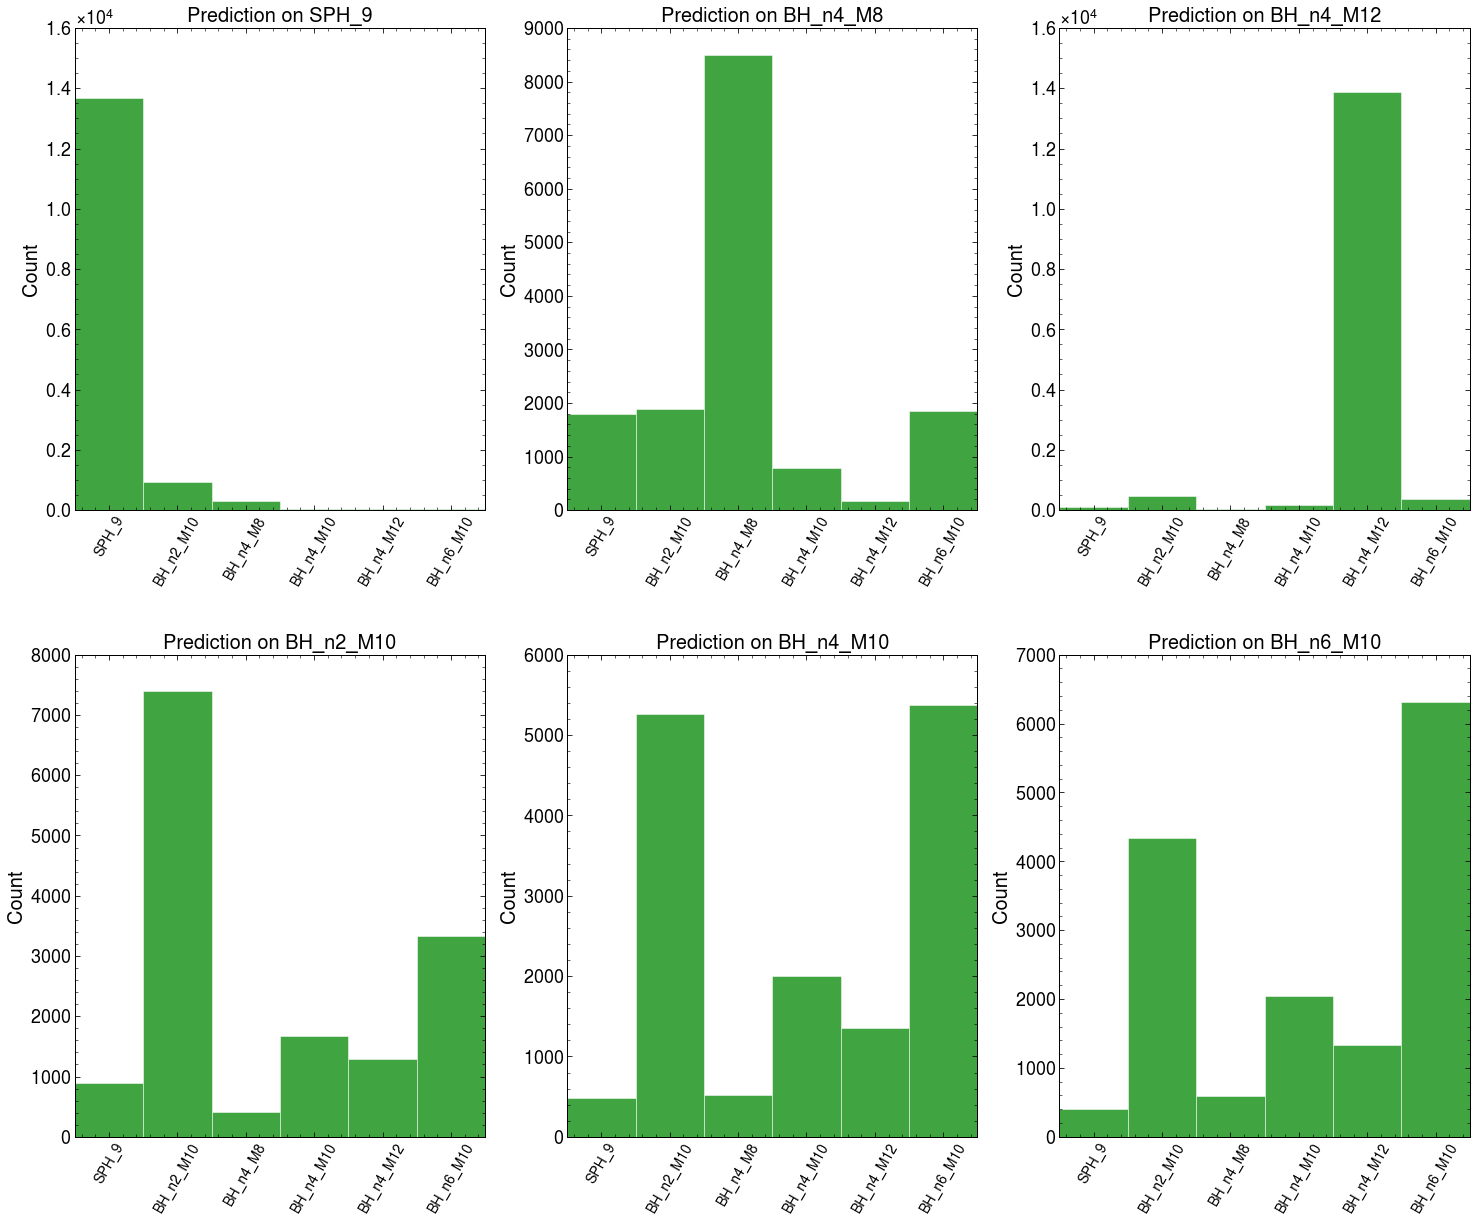

In [26]:
#Print the classifications (argmax)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
plt.subplots_adjust(hspace=0.3)
for i in range(CLASSES):
    sn.histplot(datasets[i]["Predictions"], binrange=[-0.5, CLASSES-0.5], bins=CLASSES, ax = ax[i%2][i//2])
    ax[i%2][i//2].set_title(f"Prediction on {PLOT_LABELS[i]}")
    ax[i%2][i//2].set_xticks(np.arange(0, CLASSES), PLOT_LABELS, rotation=60, fontsize=14)
    ax[i%2][i//2].set_xlabel("")
    ax[i%2][i//2].set_xlim(-0.5, CLASSES-0.5)


In [27]:
#Do this calculation just once
#Normalized prediction arrays for all datasets [hist1, hist2, ...] where hist1 = [a, b, c... d] with sum(hist1)=1
n_theory = [np.array([((len(theory[theory["Predictions"]==i])/len(theory))) for i in range(CLASSES)]) for theory in datasets]

In [28]:
#Chi2 test
def chi2(n_theory, n_data):
    return(np.sum((n_data-n_theory)**2/(n_theory)))

def chi2_method_pearson(theory, data, classes, verbose=False):

    #Number of classified particles in each class
    N_samp = len(data)
    #Number of predicted events for theory
    N_theory = theory*N_samp
    N_data = np.array([len(data[data["Predictions"]==i]) for i in range(classes)])
    #Calculate chi2_value
    chi2_value=chi2(N_theory, N_data)
    #Number of degrees of freedom
    ndof = classes-1
    #Get the p-value from the chi2
    p_value = np.float64((np.float64(1) - stats.chi2.cdf(chi2_value, ndof)))

    if verbose:
        #if p_value < 10**(-10):
        #print("p value: ", p_value)
        print(f"Histogram for data: {N_data}")
        print(f"Histogram theory: {N_theory}")
        print(f"The chi2 value for theory is {chi2_value}. The p-value is {p_value}")
    
    return p_value


In [29]:
#poisson test
def poisson(n, l):
    return((l**n)*np.exp(-l)/math.factorial(n))

def poisson_method(theory, data, classes, verbose=False):
    #Number of classified particles in each class
    N_samp = len(data)
    #Number of predicted events for theory
    N_theory = theory*N_samp
    N_data = np.array([len(data[data["Predictions"]==i]) for i in range(classes)])
    
    j_max = np.argmax(N_theory)
    lambda_j = N_theory[j_max]
    n_obs = N_data[j_max]
    p_value = np.sum([poisson(n, lambda_j) for n in range(0, n_obs+1)])

    if verbose:
        print(f"Histogram for data: {N_data}")
        print(f"Histogram theory: {N_theory}")
        print(f"The p value for theory is {p_value}")
        print(f"{lambda_j}")

    return p_value


In [30]:
# binomial test
def binomial(c, n, p):
    return((math.factorial(n)/(math.factorial(c)*math.factorial(n-c)))*(p**c)*((1-p)**(n-c)))

def binomial_method(theory, data, classes, verbose=False):
    #Number of classified particles in each class
    N_samp = len(data)
    #Number of expected events
    N_exp = theory*N_samp
    N_data = np.array([len(data[data["Predictions"]==i]) for i in range(classes)])
    
    j_max = np.argmax(N_exp)
    p_j = theory[j_max]
    n_obs = N_data[j_max]
    p_value = np.sum([binomial(n, N_samp, p_j) for n in range(0, n_obs+1)])

    if verbose:
        print(f"Empirical frequencies: {N_data}")
        print(f"Expected frequencies: {N_samp*theory}")
        print(f"The p value for theory is {p_value}")

    return p_value

In [31]:
#Test experiment 
data_id = 1
theory_id = 3
print(f"Sending in {PLOT_LABELS[data_id]}, testing against {PLOT_LABELS[theory_id]} theory")

N = 20 #number of events
k = np.random.randint(0, len(bh_2_df)-N)
experiment = datasets[data_id][k:k+N]
print("Detected events")
print(experiment)
print("..... Pearson chi2 test ....")
p1 = chi2_method_pearson(n_theory[theory_id], experiment, CLASSES, verbose=True)
print("..... Binomial test ....")
p2 = poisson_method(n_theory[theory_id], experiment, CLASSES, verbose=True)
print("..... Poisson test ....")
p3 = binomial_method(n_theory[theory_id], experiment, CLASSES, verbose=True)

Sending in BH_n2_M10, testing against BH_n4_M10 theory
Detected events
      Truth  Predictions   class_0   class_1   class_2   class_3   class_4   class_5
5318    1.0          1.0  0.034388  0.362417  0.089843  0.452145  0.003527  0.046081
5319    1.0          1.0  0.007095  0.442273  0.071906  0.330956  0.005434  0.146780
5320    1.0          5.0  0.019391  0.160675  0.148066  0.071721  0.000131  0.296451
5321    1.0          1.0  0.031202  0.326117  0.108412  0.146989  0.147455  0.037739
5322    1.0          5.0  0.389157  0.189437  0.209133  0.049983  0.000169  0.264649
...     ...          ...       ...       ...       ...       ...       ...       ...
5333    1.0          5.0  0.116050  0.187184  0.060718  0.511177  0.000512  0.114406
5334    1.0          0.0  0.010709  0.224858  0.239770  0.364121  0.012493  0.319487
5335    1.0          5.0  0.002933  0.322751  0.036440  0.504301  0.028799  0.226277
5336    1.0          4.0  0.305237  0.081242  0.282728  0.164554  0.018224  0.3

In [36]:
#get p-value as a function of number of events
N_list = np.arange(2, N_max, 1) #A list of integers from 2 to N_max

if LOAD:
    #LOAD EXPERIMENT
    p_values_p = np.load(f"../results/{STATISTIC}/{STATISTIC}_results_{MODEL_NAME}_m_{M}_p_values.npy")
    err_up_values_p = np.load(f"../results/{STATISTIC}/{STATISTIC}_results_{MODEL_NAME}_m_{M}_up_values.npy")
    err_down_values_p = np.load(f"../results/{STATISTIC}/{STATISTIC}_results_{MODEL_NAME}_m_{M}_down_values.npy")

else:
    #RUN EXPERIMENT
    #Generate M random places in the dataset to start sampling
    #k_list = [np.random.randint(0, len(datasets[0])-N_max) for i in range(0, M)]

    p_values_p = np.zeros((len(datasets), len(LABELS), len(N_list)))
    err_up_values_p = np.zeros((len(datasets), len(LABELS), len(N_list)))
    err_down_values_p = np.zeros((len(datasets), len(LABELS), len(N_list)))

    for i in tqdm(range(len(datasets))): #Iterate over all types of pseudodata
        for s, sample in enumerate(n_theory): #Iterate over all theories/samples
            for j, n in enumerate(N_list): # Iterate over number of events detected
                rand_idx = [random.sample(range(len(datasets[0])-N_max), n) for k in range(0, M)]
                experiments = [datasets[i].iloc[rand_idx[k]] for k in range(0, M)] #Generate a list of M number of experiments with n events
                if STATISTIC=="poisson":
                    results = np.array([poisson_method(sample, experiment, CLASSES) for experiment in experiments])
                elif STATISTIC=="chi2":
                    results = np.array([chi2_method_pearson(sample, experiment, CLASSES) for experiment in experiments])
                elif STATISTIC=="binomial":
                    results = np.array([binomial_method(sample, experiment, CLASSES) for experiment in experiments])
                else:
                    print("Choose an available statistic.")
                    exit()
                mean = np.average(results, axis=0)
                results_up = results[results>=mean]
                results_down = results[results<mean]
                #print(mean, results_up, results_down)
                if (len(results_up) > 0):
                    #error_up = np.sqrt(((1/len(results_up))*np.sum((results_up - mean)**2)))
                    error_up = results.max()
                else:
                    error_up = 0
                if (len(results_down) > 0):  
                    #error_down = np.sqrt(((1/len(results_down))*np.sum((results_down - mean)**2)))
                    error_down = results.min()
                else:
                    error_down = 0
                p_values_p[i][s][j] = mean
                err_up_values_p[i][s][j] = error_up
                err_down_values_p[i][s][j] = error_down


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [07:19<00:00, 73.30s/it]


In [33]:
#Save results
#if not LOAD:
#    np.save(f"../results/{STATISTIC}/{STATISTIC}_results_{MODEL_NAME}_m_{M}_p_values.npy", p_values_p)
#    np.save(f"../results/{STATISTIC}/{STATISTIC}_results_{MODEL_NAME}_m_{M}_up_values.npy", err_up_values_p)
#    np.save(f"../results/{STATISTIC}/{STATISTIC}_results_{MODEL_NAME}_m_{M}_down_values.npy", err_down_values_p)

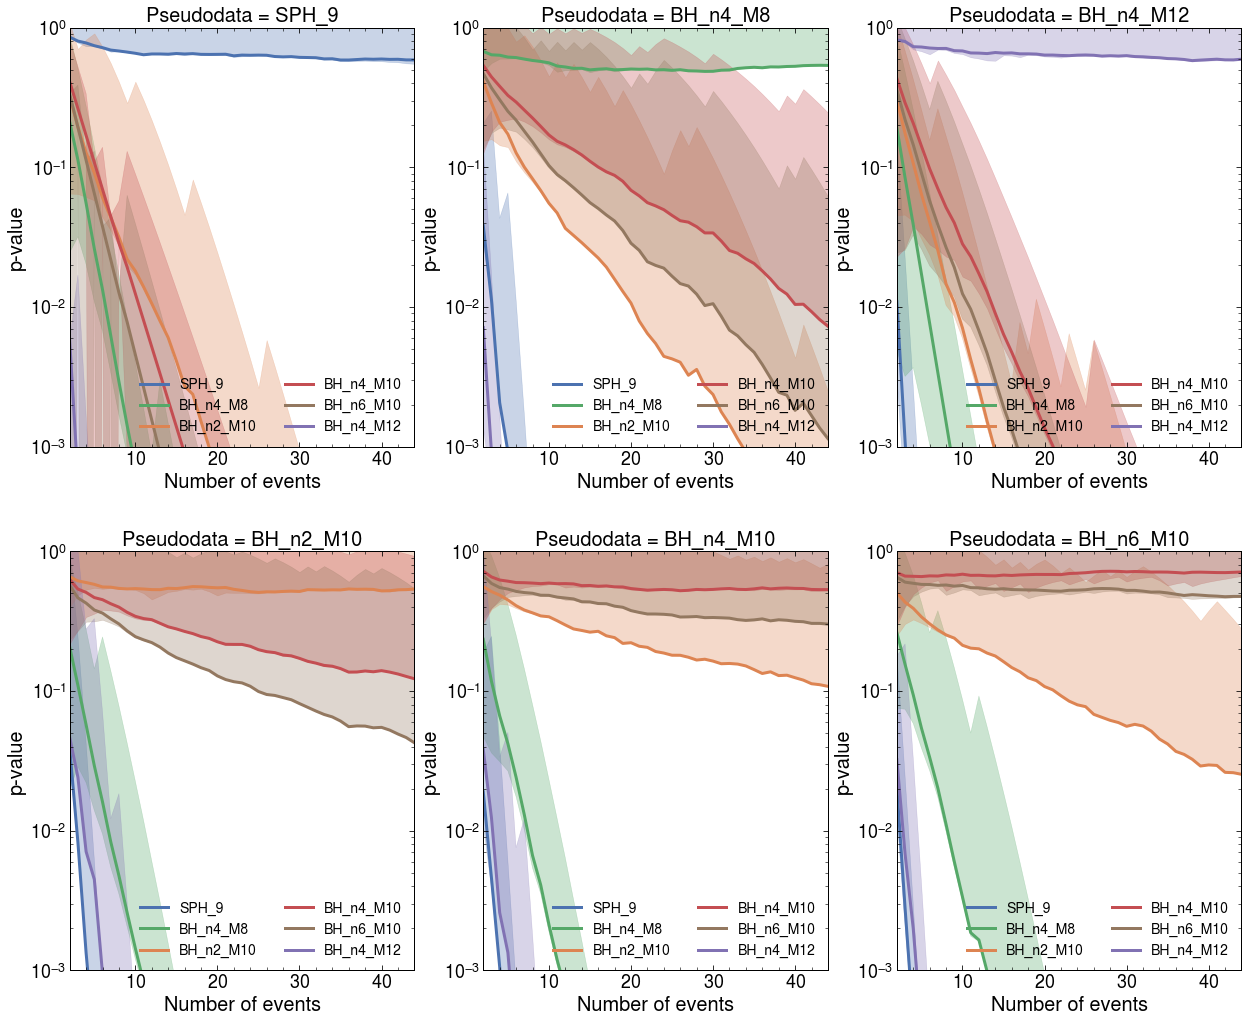

In [34]:
#Plot
fig, ax = plt.subplots(ncols = 3, nrows=2, figsize=(21, 17))
plt.subplots_adjust(hspace=0.25)
for i in range(len(PLOT_LABELS)): #iterate over pseudodata
    ax[i%2][i//2].set_title(f"Pseudodata = {PLOT_LABELS[i]}")

    for j in range(len(PLOT_LABELS)): #iterate over theories
        k = PLOT_ORDER[j]
        ax[i%2][i//2].plot(N_list, p_values_p[i][k], label=PLOT_LABELS[k], color=paper_colors[k], linewidth=3)
        ax[i%2][i//2].fill_between(N_list, p_values_p[i][k] - err_down_values_p[i][k], p_values_p[i][k] + err_up_values_p[i][k], alpha=0.3, color=paper_colors[k])

for axis in ax.reshape(-1):
    axis.set_yscale("log")
    axis.set_xlabel("Number of events")
    axis.set_ylabel("p-value")
    axis.set_xlim(2, N_max-1)
    axis.set_ylim(10**(-3), 1)
    axis.legend(loc=4, fontsize=14, ncol=2)

In [30]:
j=0
k=1
print([((p_values_p[j][k][i]), N_list[i]) for i in range(len(N_list))])
print([((err_up_values_p[j][k][i]), N_list[i]) for i in range(len(N_list))])
print([(np.log10(err_down_values_p[j][k][i]), N_list[i]) for i in range(len(N_list))])
print(PLOT_LABELS[j])

[(0.00734446627913196, 2), (3.1591554208088014e-05, 3), (1.511824750943802e-08, 4), (1.0619080744363648e-08, 5), (1.0589550717791478e-10, 6), (6.561048001193134e-14, 7), (2.2204460492503132e-17, 8), (8.289665250534502e-16, 9), (0.0, 10), (0.0, 11), (0.0, 12), (0.0, 13), (0.0, 14), (0.0, 15), (0.0, 16), (0.0, 17), (0.0, 18), (0.0, 19), (0.0, 20), (0.0, 21), (0.0, 22), (0.0, 23), (0.0, 24), (0.0, 25), (0.0, 26), (0.0, 27), (0.0, 28), (0.0, 29), (0.0, 30), (0.0, 31), (0.0, 32), (0.0, 33), (0.0, 34), (0.0, 35), (0.0, 36), (0.0, 37), (0.0, 38), (0.0, 39), (0.0, 40), (0.0, 41), (0.0, 42), (0.0, 43), (0.0, 44)]
[(0.1027602038996023, 2), (0.00015716908854166434, 3), (5.968271713507887e-08, 4), (3.0786928271557085e-07, 5), (1.4683910483598136e-09, 6), (5.666474131931885e-13, 7), (1.9984014443252818e-16, 8), (2.4040029226550056e-14, 9), (0.0, 10), (0.0, 11), (0.0, 12), (0.0, 13), (0.0, 14), (0.0, 15), (0.0, 16), (0.0, 17), (0.0, 18), (0.0, 19), (0.0, 20), (0.0, 21), (0.0, 22), (0.0, 23), (0.0, 2

/tmp/ipykernel_15763/3096048707.py:5: RuntimeWarning: divide by zero encountered in log10
  print([(np.log10(err_down_values_p[j][k][i]), N_list[i]) for i in range(len(N_list))])


In [31]:
print(PLOT_ORDER)

[0, 2, 1, 3, 5, 4]


Particles in: SPH_9, theory SPH_9
[-6.68235706e-05  1.28329746e-02  1.03585312e-01]
Particles in: SPH_9, theory BH_n4_M8
[ 0.0243178   1.32853372 -0.20582665]
Particles in: SPH_9, theory BH_n2_M10
[-0.04390804  5.12023684 -4.52919368]
Particles in: SPH_9, theory BH_n4_M10
[ 1.44323356  4.2978056  -6.33116998]
Particles in: SPH_9, theory BH_n6_M10
[ 1.38305052  3.35842356 -4.71457987]
Particles in: BH_n2_M10, theory SPH_9
[ 1.15768067 -0.82690733  1.86519049]
Particles in: BH_n2_M10, theory BH_n4_M8
[0.00435026 0.54267943 1.05120323]
Particles in: BH_n2_M10, theory BH_n2_M10
[-1.80291033e-04  1.87043490e-02  4.64347818e-01]
Particles in: BH_n2_M10, theory BH_n4_M10
[-0.00054372  0.06868911  0.37031135]
Particles in: BH_n2_M10, theory BH_n6_M10
[-0.00070277  0.08784457  0.41683394]
Particles in: BH_n2_M10, theory BH_n4_M12
[-0.04947863  4.15156633 -3.37954369]
Particles in: BH_n4_M8, theory SPH_9
[  2.8544443  -17.92729494  33.02548078]


/home/agrefsru/.conda/envs/imcal/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Particles in: BH_n4_M8, theory BH_n4_M8
[3.19463495e-05 3.01184179e-03 5.24778605e-01]
Particles in: BH_n4_M8, theory BH_n2_M10
[-0.02419901  1.54896236 -0.83140624]


Particles in: BH_n4_M8, theory BH_n4_M10
[ 0.09657778 -0.8135989   5.31307473]
Particles in: BH_n4_M8, theory BH_n6_M10
[ 0.09228454 -0.50038565  4.88049508]
Particles in: BH_n4_M8, theory BH_n4_M12
[3.11772698 1.55886349 0.77943175]
Particles in: BH_n4_M10, theory BH_n4_M8
[-0.00241164  0.77057632 -0.58256377]
Particles in: BH_n4_M10, theory BH_n2_M10
[-4.28941101e-04  4.75878238e-02  5.79948108e-01]
Particles in: BH_n4_M10, theory BH_n4_M10
[-0.0004596   0.02444187  0.43816654]
Particles in: BH_n4_M10, theory BH_n6_M10
[-0.00046593  0.03115499  0.41229442]
Particles in: BH_n4_M10, theory BH_n4_M12
[0.16635899 0.65255421 4.04831344]
Particles in: BH_n4_M12, theory BH_n4_M8
[4.44508056 2.22254028 1.11127014]
Particles in: BH_n4_M12, theory BH_n2_M10
[-0.08261354  2.90106981 -1.25841155]
Particles in: BH_n4_M12, theory BH_n4_M10
[-0.02544642  2.14619969 -0.011794  ]
Particles in: BH_n4_M12, theory BH_n6_M10
[0.0991071  0.12313028 4.61443135]
Particles in: BH_n4_M12, theory BH_n4_M12
[-0

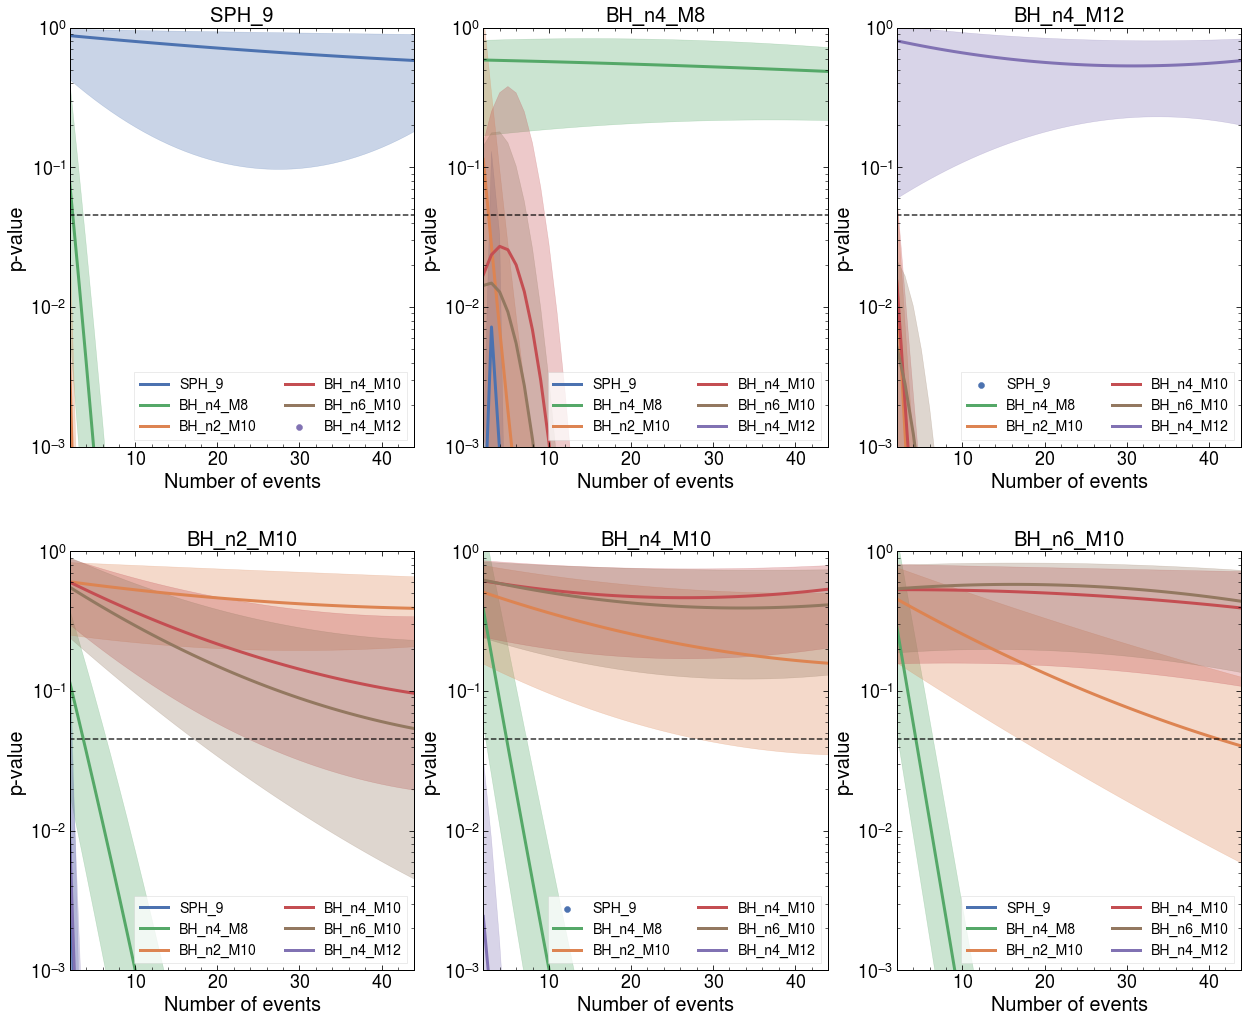

In [32]:
#Fit a nicer function to the data points
def fit_func(x, a, b, c):
    return (-a*x**2-b*x-c)
 
fig, ax = plt.subplots(ncols = 3, nrows=2, figsize=(21, 17))
plt.subplots_adjust(hspace=0.25)

for i in range(len(PLOT_LABELS)): #iterate over pseudodata
    ax[i%2][i//2].set_title(f"{PLOT_LABELS[i]}")

    for j in range(len(PLOT_LABELS)): #iterate over theories
        k = PLOT_ORDER[j]
        y_vals = p_values_p[i][k]
        err_down = err_down_values_p[i][k]
        y_lower = y_vals-err_down
        x_vals = N_list[y_lower>0]
        err_down = err_down_values_p[i][k][y_lower>0]
        err_up = err_up_values_p[i][k][y_lower>0]
        y_vals = y_vals[y_lower>0]

        if len(y_vals)>0:
            y_params, y_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(y_vals), p0=[0, 0, 0], method='dogbox')
            err_down_params, err_down_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(y_vals-err_down), p0=[0, 0, 0], method='dogbox')
            err_up_params, err_up_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(y_vals+err_up), p0=[0, 0, 0], method='dogbox')
            print(f"Particles in: {PLOT_LABELS[i]}, theory {PLOT_LABELS[k]}")
            print(y_params)

            fit_y_vals = np.exp(fit_func(x_vals, y_params[0], y_params[1], y_params[2]))
            fit_err_down = np.exp(fit_func(x_vals, err_down_params[0], err_down_params[1], err_down_params[2]))
            fit_err_up = np.exp(fit_func(x_vals, err_up_params[0], err_up_params[1], err_up_params[2]))
            #print(fit_y_vals - fit_err_down)
            
            ax[i%2][i//2].plot(x_vals, fit_y_vals, label=PLOT_LABELS[k], color=paper_colors[k], linewidth=3)
            #ax[i%2][i//2].plot(x_vals, fit_err_down, label=PLOT_LABELS[k], color=paper_colors[k], linewidth=2, linestyle="--", alpha=0.8)
            ax[i%2][i//2].fill_between(x_vals, fit_err_down, fit_err_up, alpha=0.3, color=paper_colors[k])
        
        else:
            ax[i%2][i//2].scatter(x_vals, y_vals, label=PLOT_LABELS[k], color=paper_colors[k])

for axis in ax.reshape(-1):
    axis.set_yscale("log")
    axis.set_xlabel("Number of events")
    axis.set_ylabel("p-value")
    axis.set_xlim(2, N_max-1)
    axis.set_ylim(10**(-3), 1)
    axis.legend(loc=4, fontsize=14, ncol=2, frameon=True)
    excl_x = np.linspace(0, 50, 20)
    axis.plot(excl_x, [0.0455]*len(excl_x), color="black", linestyle="--", alpha=0.8)

/home/agrefsru/.conda/envs/imcal/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/agrefsru/.conda/envs/imcal/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/agrefsru/.conda/envs/imcal/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/agrefsru/.conda/envs/imcal/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


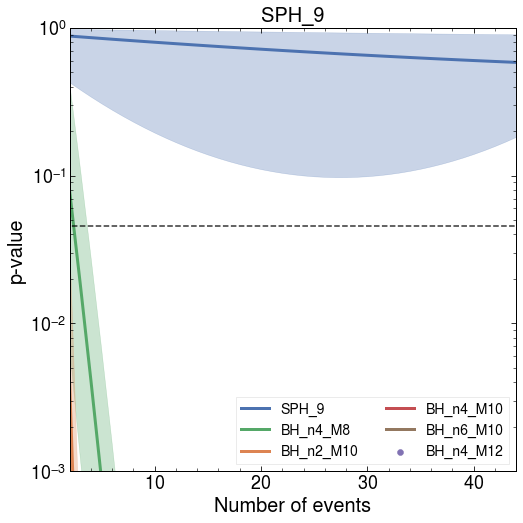

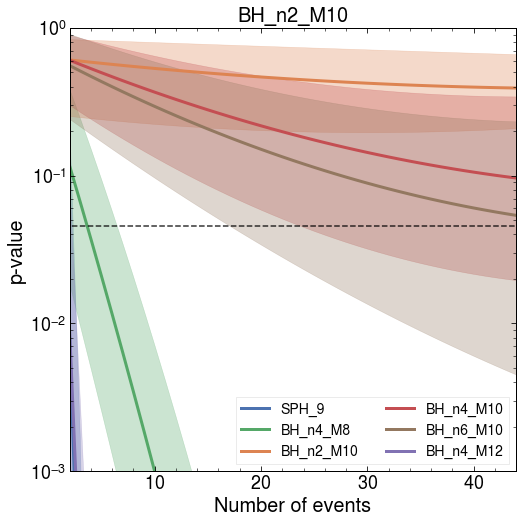

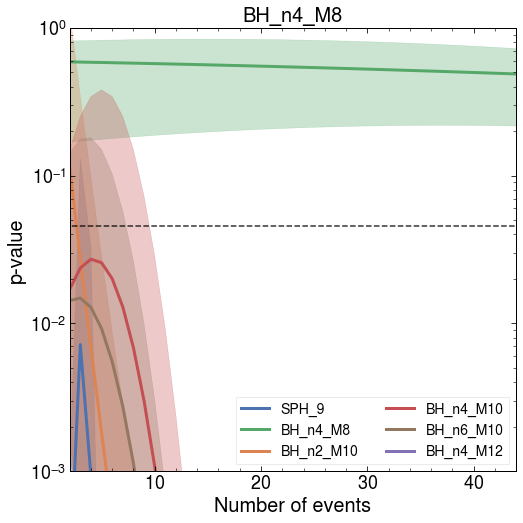

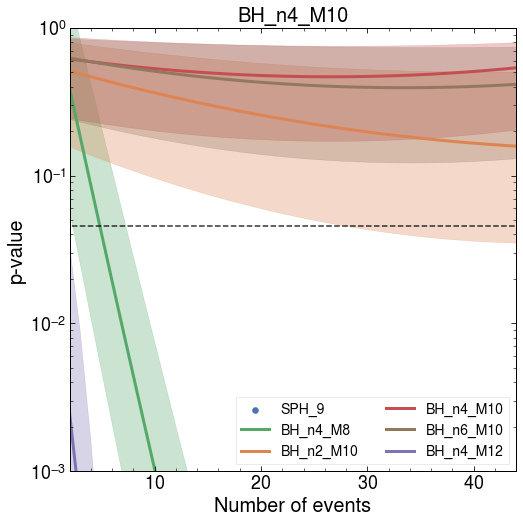

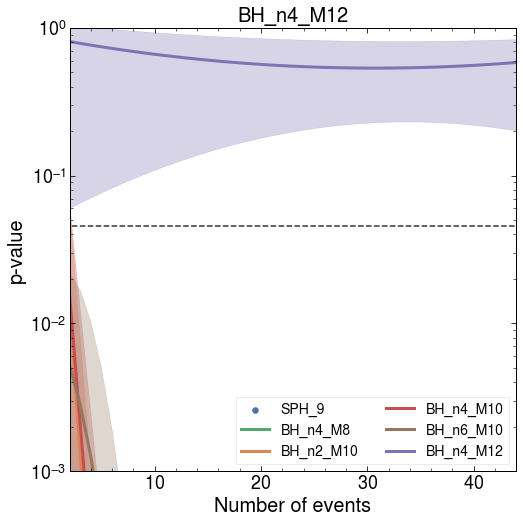

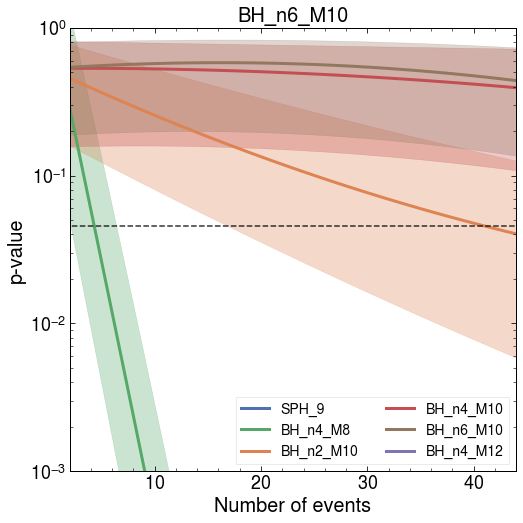

In [33]:
#Save figures for paper

for i in range(len(PLOT_LABELS)): #iterate over pseudodata
    
    fig, ax = plt.subplots(ncols = 1, nrows=1, figsize=(8, 8))
    ax.set_title(f"{PLOT_LABELS[i]}")

    for j in range(len(PLOT_LABELS)): #iterate over theories
        k = PLOT_ORDER[j]
        y_vals = p_values_p[i][k]
        err_down = err_down_values_p[i][k]
        y_lower = y_vals-err_down
        x_vals = N_list[y_lower>0]
        err_down = err_down_values_p[i][k][y_lower>0]
        err_up = err_up_values_p[i][k][y_lower>0]
        y_vals = y_vals[y_lower>0]

        if len(y_vals)>0:
            y_params, y_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(y_vals), p0=[0, 0, 0], method='dogbox')
            err_down_params, err_down_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(y_vals-err_down), p0=[0, 0, 0], method='dogbox')
            err_up_params, err_up_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(y_vals+err_up), p0=[0, 0, 0], method='dogbox')
            #print(f"Particles in: {PLOT_LABELS[i]}, theory {PLOT_LABELS[k]}")
            #print(y_params)

            fit_y_vals = np.exp(fit_func(x_vals, y_params[0], y_params[1], y_params[2]))
            fit_err_down = np.exp(fit_func(x_vals, err_down_params[0], err_down_params[1], err_down_params[2]))
            fit_err_up = np.exp(fit_func(x_vals, err_up_params[0], err_up_params[1], err_up_params[2]))
            #print(fit_y_vals - fit_err_down)
            
            ax.plot(x_vals, fit_y_vals, label=PLOT_LABELS[k], color=paper_colors[k], linewidth=3)
            #ax[i%2][i//2].plot(x_vals, fit_err_down, label=PLOT_LABELS[k], color=paper_colors[k], linewidth=2, linestyle="--", alpha=0.8)
            ax.fill_between(x_vals, fit_err_down, fit_err_up, alpha=0.3, color=paper_colors[k])
        
        else:
            ax.scatter(x_vals, y_vals, label=PLOT_LABELS[k], color=paper_colors[k])

    ax.set_yscale("log")
    ax.set_xlabel("Number of events")
    ax.set_ylabel("p-value")
    ax.set_xlim(2, N_max-1)
    ax.set_ylim(10**(-3), 1)
    ax.legend(loc=4, fontsize=14, ncol=2, frameon=True)
    excl_x = np.linspace(0, 50, 20)
    ax.plot(excl_x, [0.0455]*len(excl_x), color="black", linestyle="--", alpha=0.8)

    fig.savefig(f"../results/figures/{STATISTIC}_M_{M}_Ntest_{TEST_N_EVENTS}_p_values_{PLOT_LABELS[i]}.pdf", format="pdf", bbox_inches='tight')